In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from utils.engine import train_one_epoch, evaluate

## Configure Path

In [2]:
DATABASE_BASE = "/home/mirap/0_DATABASE/1_sperm_acrosome_reaction/1_AR_400/"
train_csv_path = DATABASE_BASE + "csv/exp_set_1_train_labels.csv"
test_csv_path = DATABASE_BASE + "csv/exp_set_1_val_labels.csv"
train_image_path = DATABASE_BASE + "set1"
test_image_path = DATABASE_BASE + "5_folds/fold_5"
model_save_path = "trained_model/1_AR_400/v1/"
model_save_name = model_save_path + "faster_rcnn_resnet50_fpn_set1"

## Check data

In [3]:
train_csv = pd.read_csv(train_csv_path)
print(train_csv.shape)
train_csv.head()

(2848, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,190305_D253_MO_400X_(100).JPG,1200,800,AR,340,748,382,780
1,190305_D253_MO_400X_(100).JPG,1200,800,AR,681,654,733,685
2,190305_D253_MO_400X_(100).JPG,1200,800,AR,924,642,962,671
3,190305_D253_MO_400X_(100).JPG,1200,800,AR,96,240,137,278
4,190305_D253_MO_400X_(100).JPG,1200,800,AR,496,530,540,557


In [4]:
test_csv = pd.read_csv(test_csv_path)
print(test_csv.shape)
test_csv.head()

(748, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,190305_D253_MO_400X_(1).JPG,1200,800,AR,60,350,103,400
1,190305_D253_MO_400X_(1).JPG,1200,800,AR,92,1,144,43
2,190305_D253_MO_400X_(1).JPG,1200,800,AR,556,200,602,263
3,190305_D253_MO_400X_(1).JPG,1200,800,AR,298,270,340,317
4,190305_D253_MO_400X_(1).JPG,1200,800,AR,215,192,252,233


In [5]:
categories = train_csv["class"].unique()
print(categories)

['AR' 'Non_AR']


## Encoding classes to integers
* 0 is for background

In [6]:
# Encoding functions
class LabelMap:
    def __init__(self, categories):
        self.map_dict = {}
        self.reverse_map_dict={}
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat
    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df
    def inverse(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

In [7]:
label_map = LabelMap(categories)

In [8]:
train_csv = label_map.fit(train_csv, "class")
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,190305_D253_MO_400X_(100).JPG,1200,800,1,340,748,382,780
1,190305_D253_MO_400X_(100).JPG,1200,800,1,681,654,733,685
2,190305_D253_MO_400X_(100).JPG,1200,800,1,924,642,962,671
3,190305_D253_MO_400X_(100).JPG,1200,800,1,96,240,137,278
4,190305_D253_MO_400X_(100).JPG,1200,800,1,496,530,540,557


In [9]:
test_csv = label_map.fit(test_csv, "class")
test_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,190305_D253_MO_400X_(1).JPG,1200,800,1,60,350,103,400
1,190305_D253_MO_400X_(1).JPG,1200,800,1,92,1,144,43
2,190305_D253_MO_400X_(1).JPG,1200,800,1,556,200,602,263
3,190305_D253_MO_400X_(1).JPG,1200,800,1,298,270,340,317
4,190305_D253_MO_400X_(1).JPG,1200,800,1,215,192,252,233


## Torch Dataset Creation

In [12]:
class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_path, categories, transforms=None,**kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.image_path = image_path
        self.categories = categories
        self.images = self.df["filename"].unique()
        self.transforms = transforms
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_file = os.path.join(self.image_path, self.images[idx])
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        image_data = self.df[self.df['filename'] == self.images[idx]]
        labels = torch.as_tensor(image_data["class"].values, dtype=torch.int64)
        xmins = image_data["xmin"].values
        ymins = image_data["ymin"].values
        xmaxs = image_data["xmax"].values
        ymaxs = image_data["ymax"].values
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"],dtype=torch.float32)
        return torch.as_tensor(img, dtype=torch.float32), target
    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data["width"].values[0], image_data["height"].values[0]

## Data Augmentation

In [13]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [14]:
transform_test = A.Compose([
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

## Dataloader creation

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_dataset = AnimalDataset(train_csv, train_image_path, categories, transform_train)
test_dataset = AnimalDataset(test_csv, test_image_path, categories, transform_test)

In [17]:
data_loader_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=collate_fn)
    
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

## Plot images from dataloader

In [18]:
def plot_images(images, targets):
    for image, target in zip(images, targets):
        sample = image.permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        boxes = target["boxes"].cpu().numpy().astype(np.int32)
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        ax.set_axis_off()
        ax.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train batch


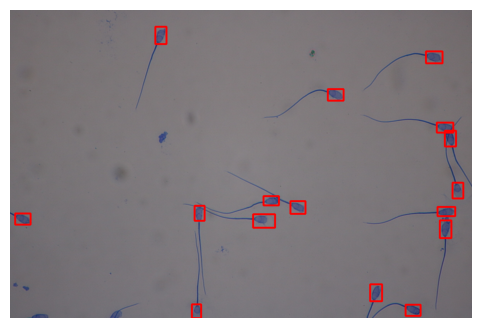

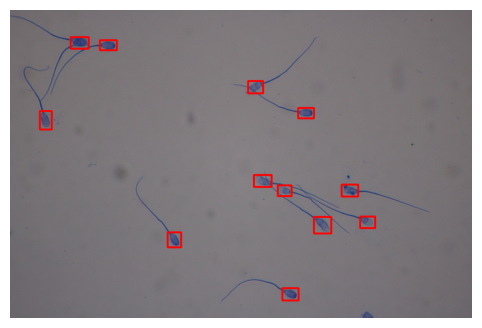

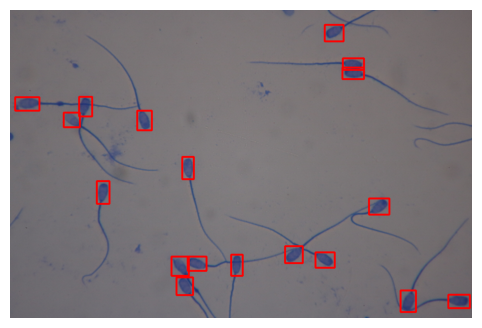

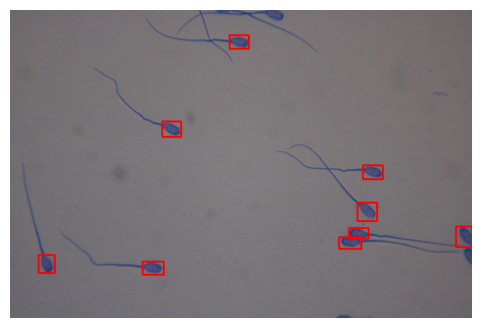

In [17]:
images, targets = next(iter(data_loader_train))
print("Train batch")
plot_images(images, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test batch


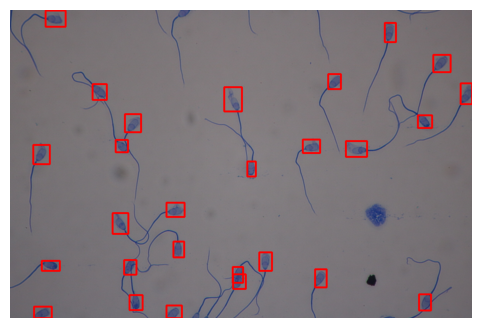

In [18]:
images, targets = next(iter(data_loader_test))
print("test batch")
plot_images(images, targets)

## Training

import model from torchvision library </br>
https://pytorch.org/vision/0.11/models.html

In [19]:
import torchvision.models.detection as torch_det

# detection_model = torch_det.fasterrcnn_resnet50_fpn(pretrained=True)

# ... Alternatives ...
# detection_model = torch_det.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
detection_model = torch_det.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# detection_model = torch_det.ssdlite320_mobilenet_v3_large(pretrained=True)
# detection_model = torch_det.ssd300_vgg16(pretrained=True)
# detection_model = torch_det.retinanet_resnet50_fpn(pretrained=True)

/home/mirap/.conda/envs/tf2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mirap/.conda/envs/tf2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /home/mirap/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

adjust classes

In [20]:
num_classes = len(categories)+1 # add background class

In [21]:
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features

detection_model.roi_heads.box_predictor = torch_det.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

GPU load try and mount the model

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
detection_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

Training and validation config

In [25]:
def training(model, train_loader, val_loader, epochs=10):
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    
    for epoch in range(epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=20)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, val_loader, device=device)

In [26]:
history = training(detection_model, data_loader_train, data_loader_test, epochs=10 )

Epoch: [0]  [  0/137]  eta: 0:04:10  lr: 0.000042  loss: 2.1042 (2.1042)  loss_classifier: 1.3699 (1.3699)  loss_box_reg: 0.5751 (0.5751)  loss_objectness: 0.1104 (0.1104)  loss_rpn_box_reg: 0.0488 (0.0488)  time: 1.8272  data: 0.2050  max mem: 513
Epoch: [0]  [ 20/137]  eta: 0:00:16  lr: 0.000776  loss: 1.5895 (1.7561)  loss_classifier: 0.6528 (0.8541)  loss_box_reg: 0.7039 (0.6361)  loss_objectness: 0.0916 (0.2036)  loss_rpn_box_reg: 0.0547 (0.0623)  time: 0.0563  data: 0.0046  max mem: 610
Epoch: [0]  [ 40/137]  eta: 0:00:09  lr: 0.001511  loss: 1.1984 (1.4807)  loss_classifier: 0.4221 (0.6561)  loss_box_reg: 0.6581 (0.6426)  loss_objectness: 0.0422 (0.1292)  loss_rpn_box_reg: 0.0385 (0.0527)  time: 0.0466  data: 0.0040  max mem: 610
Epoch: [0]  [ 60/137]  eta: 0:00:06  lr: 0.002245  loss: 1.0030 (1.3226)  loss_classifier: 0.4287 (0.5807)  loss_box_reg: 0.5068 (0.5980)  loss_objectness: 0.0252 (0.0966)  loss_rpn_box_reg: 0.0325 (0.0473)  time: 0.0557  data: 0.0040  max mem: 610
Epoc

Epoch: [2]  [100/137]  eta: 0:00:01  lr: 0.005000  loss: 0.8675 (0.8583)  loss_classifier: 0.3036 (0.3071)  loss_box_reg: 0.4705 (0.4975)  loss_objectness: 0.0178 (0.0254)  loss_rpn_box_reg: 0.0222 (0.0283)  time: 0.0533  data: 0.0037  max mem: 610
Epoch: [2]  [120/137]  eta: 0:00:00  lr: 0.005000  loss: 0.8885 (0.8602)  loss_classifier: 0.3224 (0.3111)  loss_box_reg: 0.4603 (0.4936)  loss_objectness: 0.0270 (0.0261)  loss_rpn_box_reg: 0.0309 (0.0293)  time: 0.0425  data: 0.0035  max mem: 610
Epoch: [2]  [136/137]  eta: 0:00:00  lr: 0.005000  loss: 0.6939 (0.8469)  loss_classifier: 0.2185 (0.3047)  loss_box_reg: 0.4119 (0.4882)  loss_objectness: 0.0206 (0.0256)  loss_rpn_box_reg: 0.0236 (0.0284)  time: 0.0416  data: 0.0035  max mem: 610
Epoch: [2] Total time: 0:00:06 (0.0478 s / it)
creating index...
index created!
Test:  [ 0/35]  eta: 0:00:10  model_time: 0.0232 (0.0232)  evaluator_time: 0.0225 (0.0225)  time: 0.3034  data: 0.2552  max mem: 610
Test:  [34/35]  eta: 0:00:00  model_time

Epoch: [5]  [  0/137]  eta: 0:00:44  lr: 0.000500  loss: 0.6246 (0.6246)  loss_classifier: 0.2154 (0.2154)  loss_box_reg: 0.3509 (0.3509)  loss_objectness: 0.0204 (0.0204)  loss_rpn_box_reg: 0.0379 (0.0379)  time: 0.3260  data: 0.2815  max mem: 610
Epoch: [5]  [ 20/137]  eta: 0:00:06  lr: 0.000500  loss: 0.6254 (0.6635)  loss_classifier: 0.2354 (0.2284)  loss_box_reg: 0.3891 (0.4007)  loss_objectness: 0.0135 (0.0205)  loss_rpn_box_reg: 0.0062 (0.0139)  time: 0.0421  data: 0.0033  max mem: 610
Epoch: [5]  [ 40/137]  eta: 0:00:05  lr: 0.000500  loss: 0.7465 (0.7145)  loss_classifier: 0.2578 (0.2462)  loss_box_reg: 0.4486 (0.4256)  loss_objectness: 0.0237 (0.0248)  loss_rpn_box_reg: 0.0158 (0.0179)  time: 0.0495  data: 0.0034  max mem: 610
Epoch: [5]  [ 60/137]  eta: 0:00:03  lr: 0.000500  loss: 0.6769 (0.7163)  loss_classifier: 0.2485 (0.2516)  loss_box_reg: 0.3876 (0.4246)  loss_objectness: 0.0170 (0.0239)  loss_rpn_box_reg: 0.0127 (0.0163)  time: 0.0458  data: 0.0034  max mem: 610
Epoc

Epoch: [7]  [100/137]  eta: 0:00:01  lr: 0.000050  loss: 0.6336 (0.6871)  loss_classifier: 0.2179 (0.2387)  loss_box_reg: 0.3571 (0.4092)  loss_objectness: 0.0152 (0.0217)  loss_rpn_box_reg: 0.0113 (0.0176)  time: 0.0404  data: 0.0033  max mem: 610
Epoch: [7]  [120/137]  eta: 0:00:00  lr: 0.000050  loss: 0.5687 (0.6754)  loss_classifier: 0.2100 (0.2336)  loss_box_reg: 0.3277 (0.4016)  loss_objectness: 0.0187 (0.0224)  loss_rpn_box_reg: 0.0126 (0.0178)  time: 0.0415  data: 0.0034  max mem: 610
Epoch: [7]  [136/137]  eta: 0:00:00  lr: 0.000050  loss: 0.6183 (0.6798)  loss_classifier: 0.2241 (0.2342)  loss_box_reg: 0.3590 (0.4054)  loss_objectness: 0.0233 (0.0226)  loss_rpn_box_reg: 0.0144 (0.0176)  time: 0.0410  data: 0.0033  max mem: 610
Epoch: [7] Total time: 0:00:06 (0.0473 s / it)
creating index...
index created!
Test:  [ 0/35]  eta: 0:00:11  model_time: 0.0225 (0.0225)  evaluator_time: 0.0202 (0.0202)  time: 0.3252  data: 0.2800  max mem: 610
Test:  [34/35]  eta: 0:00:00  model_time

## SAVE MODEL

In [27]:
# Create directory if not exist
os.makedirs(model_save_path, exist_ok=True)

# Save model (parameters only)
torch.save(detection_model.state_dict(), model_save_name+'.pth')

In [28]:
detection_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):